Import the basic modules, machine learning modules, and visualization modules used. 

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold, train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

1. Use sqlite3 to retrieve data from basketball.db
2. View the basic information of the data table and print the first few rows of two important tables.

In [4]:
db_path = 'basketball.db'
datasql = sqlite3.connect(db_path)
cursor = datasql.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables = [tbl[0] for tbl in tables] 
print("All Tables in the Database：")
for table in tables:
    print(table)
for table in tables:
    print(f"The Structure of Table'{table}'")
    cursor = datasql.execute(f"PRAGMA table_info(`{table}`);")
    columns = cursor.fetchall()
    for col in columns:
        cid, name, col_type, notnull, dflt_value, pk = col
        pk_str = " (PRIMARY KEY)" if pk else ""
        print(f"  {name} {col_type}{pk_str}")
for table in ['players', 'player_regular_season']:
    if table in tables:
        print(f"The First 5 Rows of the'{table}' Table. ")
        data5 = pd.read_sql_query(f"SELECT * FROM `{table}` LIMIT 5;", datasql)
        print(data5.to_string(index=False))
        print()

All Tables in the Database：
players
player_regular_season
player_regular_season_career
player_playoffs
player_playoffs_career
player_allstar
teams
team_season
draft
coaches_season
coaches_career
data_dictionary
The Structure of Table'players'
  ilkid TEXT
  firstname TEXT
  lastname TEXT
  position TEXT
  firstseason REAL
  lastseason REAL
  h_feet REAL
  h_inches REAL
  weight REAL
  college TEXT
  birthdate TEXT
The Structure of Table'player_regular_season'
  ilkid TEXT
  year INTEGER
  firstname TEXT
  lastname TEXT
  team TEXT
  leag TEXT
  gp REAL
  minutes REAL
  pts REAL
  oreb REAL
  dreb REAL
  reb REAL
  asts REAL
  stl REAL
  blk REAL
  turnover REAL
  pf REAL
  fga REAL
  fgm REAL
  fta REAL
  ftm REAL
  tpa REAL
  tpm REAL
The Structure of Table'player_regular_season_career'
  ilkid TEXT
  firstname TEXT
  lastname TEXT
  leag TEXT
  gp REAL
  minutes REAL
  pts REAL
  oreb REAL
  dreb REAL
  reb REAL
  asts REAL
  stl REAL
  blk REAL
  turnover REAL
  pf REAL
  fga REAL
 

1. Due to the unique common key value "ilkid" in both the playr_regularizer_sea and players tables, use "join" to connect the data of these two tables using "ilkid".
2. And use 'WHERE. minutes>0' to represent retaining only appearance records with a time>0.

In [5]:
q= """
SELECT p.ilkid, p.firstname, p.lastname, p.position, p.birthdate,
s.year, s.minutes, s.pts, s.oreb, s.dreb, s.reb, s.asts, 
s.stl, s.blk, s.turnover, s.fga, s.fgm, s.fta, s.ftm, s.tpa, s.tpm
FROM player_regular_season s
JOIN players p ON s.ilkid = p.ilkid
WHERE s.minutes > 0
"""
data= pd.read_sql_query(q, datasql)
datasql.close()

1. Convert 'birthdate' to datetime type, and replace invalid values with NaN
2. Age = Season year - Birthdate

In [ ]:
data['birthdate'] = pd.to_datetime(data['birthdate'], errors='coerce')
data['Age'] = data['year']-data['birthdate'].dt.year

Data anomaly handling and filtering:
1. Select relevant features that may be used.
2. Due to various scoring scenarios, missing or abnormal values in the features are padded with 0.
3. Since age is an essential feature, data with abnormal age characteristics will be deleted.
4. Select contestants aged between 18 and 45

In [7]:
features = ['pts', 'reb', 'asts', 'stl', 'blk', 'turnover', 'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm']
data[features] = data[features].fillna(0) 
data = data.dropna(subset=['Age'])
data_clean = data[(data['Age'] >= 18) & (data['Age'] <= 45)].copy()

1. Due to the varying playing conditions, playing time, and scoring situations of different players in the data, it is impossible to make comparisons. Therefore, it is necessary to calculate the scoring situation per minute and then multiply it by 36 minutes to obtain the score for a game.
2. The average playing time of 36 minutes is selected after consulting relevant materials, with many sources using 36 minutes as a standard for statistics.

In [8]:
for fea in features:
    data_clean[f'{fea}_36'] =36*(data_clean[fea]/data_clean['minutes'])

1. Group data_clean by Age and position, calculate the mean of the 'pts_36' score list, and then transform the table into a format where rows represent Age and columns represent position.
2. Plot a line graph with age on the x-axis and score on the y-axis, showing how score varies with age.

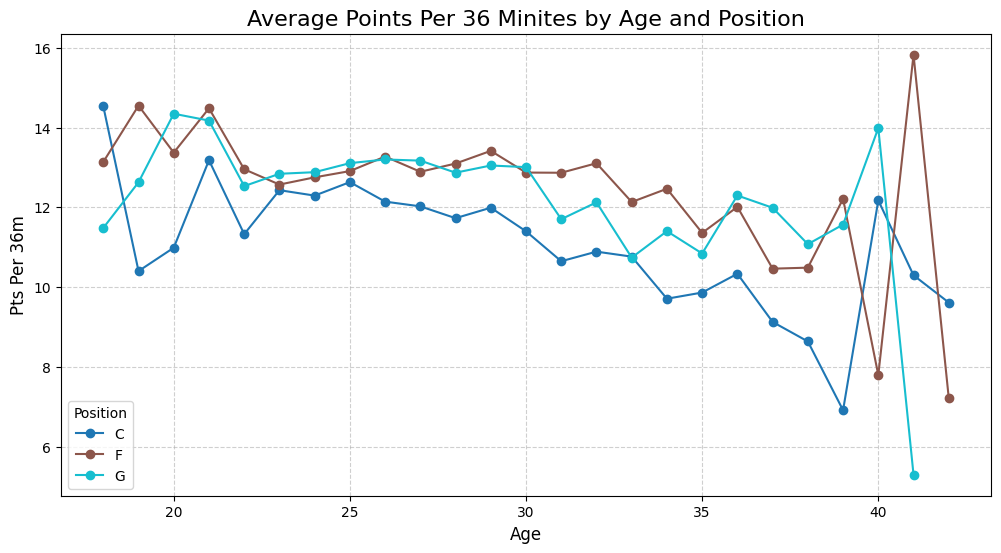

In [9]:
data1 = data_clean.groupby(['Age', 'position'])['pts_36'].mean().unstack()
plt.figure(figsize=(12, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(data1.columns))) 
for c, column in enumerate(data1.columns):  
    plt.plot(data1.index, data1[column], marker='o', label=column, color=colors[c])
plt.title('Average Points Per 36 Minites by Age and Position', fontsize=16) 
plt.xlabel('Age', fontsize=12) 
plt.ylabel('Pts Per 36m', fontsize=12)
plt.legend(title='Position') 
plt.grid(True, linestyle='--', alpha=0.6) 
plt.savefig(os.path.join('images/eda_age_trajectory.png'))
plt.show()
plt.close()

1. For each 'position', extract the assists 'asts_36' and form a list data2. 
2. Plot a boxplot of assists distribution for different positions, with position as the x-axis and assists 'asts_36' as the y-axis. 

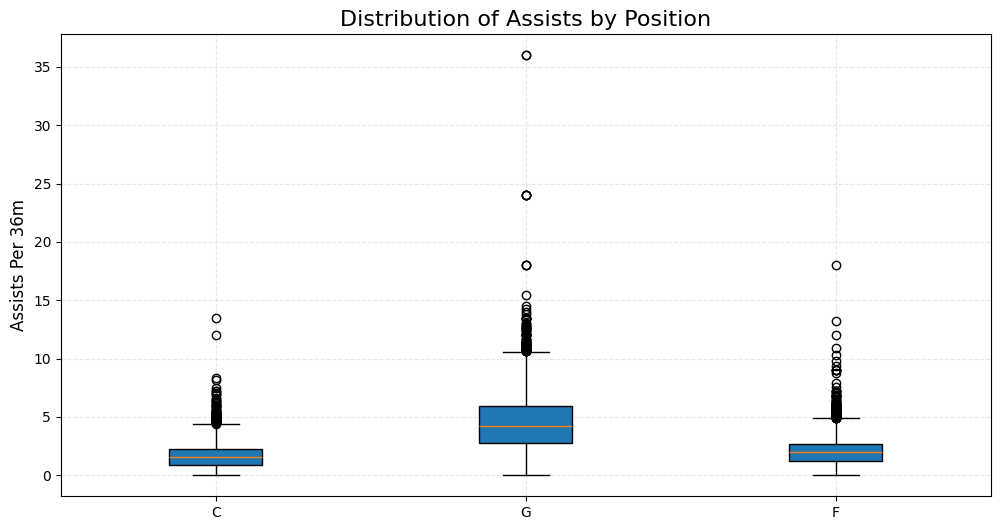

In [10]:
positions = data_clean['position'].unique()
data2 = [data_clean[data_clean['position'] == p]['asts_36'] for p in positions]
plt.figure(figsize=(12, 6))
plt.boxplot(data2, tick_labels=positions, patch_artist=True)
plt.title('Distribution of Assists by Position', fontsize=16)
plt.ylabel('Assists Per 36m', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig(os.path.join('images/eda_position_distribution.png'))
plt.show()
plt.close()

1. Standardize the data.
2. Divide the dataset into training set, validation set, and test set in a ratio of 70:15:15. 

In [11]:

y1 = data_clean[features].values  
scaler =StandardScaler() 
data_final = scaler.fit_transform(y1)
x_train, xx, y_train, yy = train_test_split(
    data_final, 
    data_clean, 
    test_size=0.3,
    random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    xx, 
    yy, 
    test_size=0.5,
    random_state=42
)
print(f"Training Numbers: {len(x_train)}, Val Numbers: {len(x_val)}, Test Numbers: {len(x_test)}")

Training Numbers: 11367, Val Numbers: 2436, Test Numbers: 2436


1. Use PCA dimensionality reduction to examine the importance level of 12 features and rank them accordingly.
2. Select the top 9 features with an absolute load value greater than 0.2. 
3. Use PCA to reduce the 9-dimensional feature space to 2 principal components, making it easier to project the data onto a 2D plane for visualization. 

In [12]:
pca = PCA(n_components=2)
pca.fit(x_train) 
data_pca = pca.transform(data_final)
loadings = pca.components_[0] 
feature_importance = np.abs(loadings)
top_indices = np.argsort(feature_importance)[::-1][:12]
top_features = [features[i] for i in top_indices]
print("Important Features:", top_features)

for i in top_indices:
    print(f"{features[i]}: importance = {feature_importance[i]:.4f}")

feature1 = ['pts', 'fgm', 'fga', 'ftm', 'fta', 'asts', 'turnover', 'reb', 'stl']
y_train=y_train[feature1]
y_val=y_val[feature1]
y_test=y_test[feature1]

Important Features: ['pts', 'fgm', 'fga', 'ftm', 'fta', 'asts', 'turnover', 'reb', 'stl', 'tpa', 'blk', 'tpm']
pts: importance = 0.3628
fgm: importance = 0.3568
fga: importance = 0.3522
ftm: importance = 0.3453
fta: importance = 0.3443
asts: importance = 0.2894
turnover: importance = 0.2757
reb: importance = 0.2705
stl: importance = 0.2567
tpa: importance = 0.1671
blk: importance = 0.1665
tpm: importance = 0.1571


1. Use the k-means model for clustering, adjust the hyperparameter k from 2-8, and find the most accurate k value. 

In [ ]:
results={} 
inertia = []
avgs = []
klist = range(2, 9)
best_k = 2
best = -1
for k in klist:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(x_train)
    score = silhouette_score(x_train, labels)
    avgs.append(score)
    inertia.append(model.inertia_)
    if score > best:
        best = score
        best_k = k
    print(f"K={k}, Silhouette Score={score:.4f}")
print(f"Best K: {best_k}")

K=2, Silhouette Score=0.4375
K=3, Silhouette Score=0.4401
K=4, Silhouette Score=0.3470
K=5, Silhouette Score=0.3366
K=6, Silhouette Score=0.3325
K=7, Silhouette Score=0.3431
K=8, Silhouette Score=0.3179
Best K: 3


1. Simultaneously plot the curves of inertia and contour coefficient as a function of K. 
2. The blue line represents the trend of Inertia, and the red line represents the trend of silhouette coefficient.
3. As shown in the figure, the best effect is achieved when k=3. 

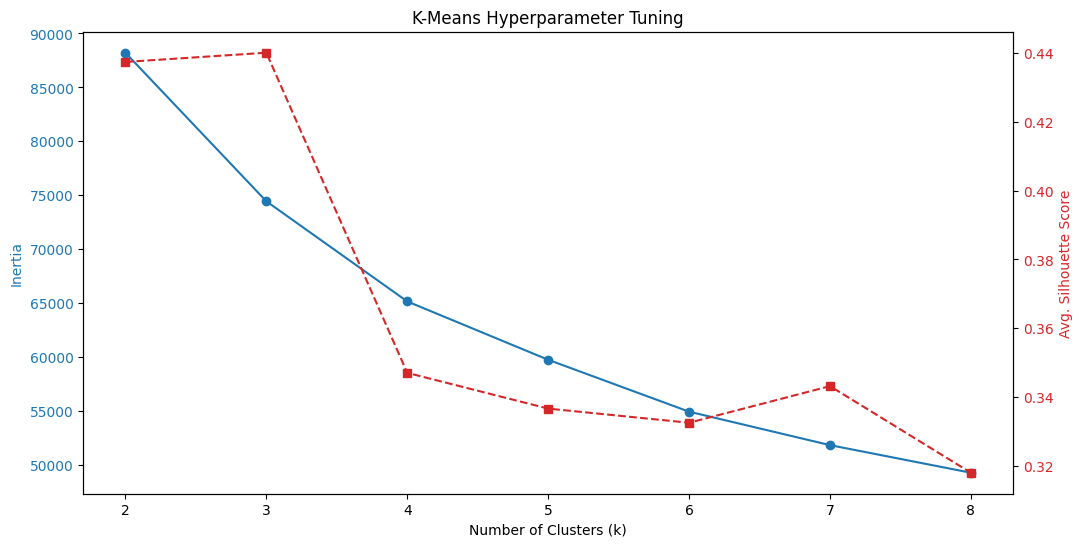

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(klist, inertia, color='tab:blue', marker='o', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Avg. Silhouette Score', color='tab:red')
ax2.plot(klist, avgs, color='tab:red', marker='s', linestyle='--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('K-Means Hyperparameter Tuning')
plt.savefig(os.path.join('images/model_kmeans_tuning.png'))
plt.show()
plt.close()

1. When K=3, the evaluation of K-Means on the validation set. 
2. Record the best results of K-Means. 

In [16]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(x_train)
labels_kmeans = kmeans.predict(x_val)
score1 = silhouette_score(x_val, labels_kmeans)
results['KMeans'] = score1
print(f" K-Means Scores: {score1:.4f}")

 K-Means Scores: 0.4600


Visualize the final clustering results. 

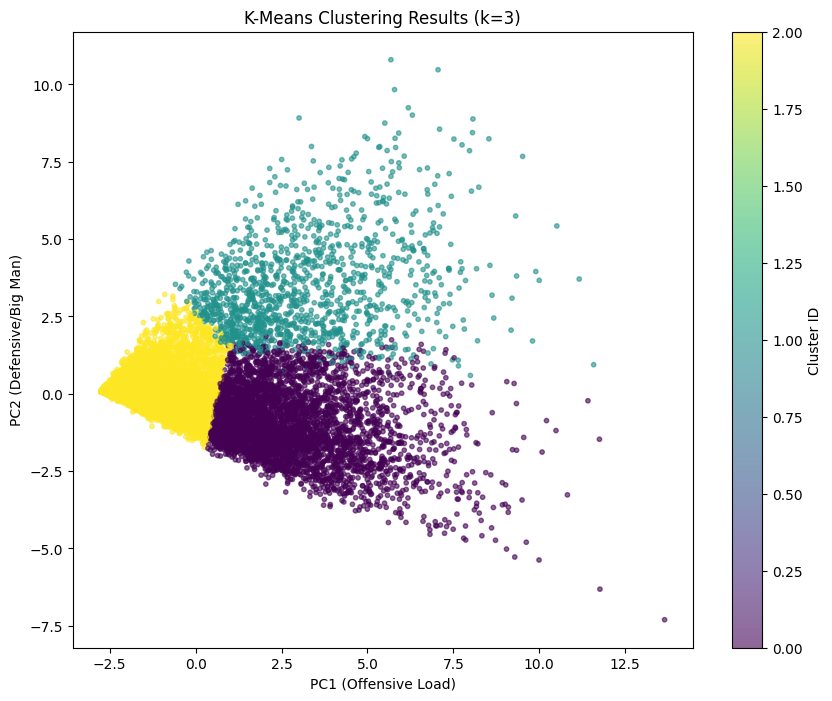

In [17]:
labels_kmeans1 = kmeans.predict(data_final)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_kmeans1, cmap='viridis', alpha=0.6, s=10)
plt.title(f'K-Means Clustering Results (k={best_k})')
plt.xlabel('PC1 (Offensive Load)')
plt.ylabel('PC2 (Defensive/Big Man)')
plt.colorbar(scatter, label='Cluster ID')
plt.savefig(('images/model_kmeans_result.png'))
plt.show()
plt.close()

Use the DBSCAN model for density based clustering and adjust the hyperparameter eps between 1.0-2.0 to find the optimal value.

In [22]:
epsl = np.linspace(1, 2, 20)
best_eps = 0.8
best = -1
for eps in epsl:
    model = DBSCAN(eps=eps, min_samples=5)
    labels = model.fit_predict(x_train)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    if n_clusters >= 2:
        score = silhouette_score(x_train, labels)
    else:
        score = -1
    print(f"Eps={eps:.4f}, Silhouette Score={score:.4f}")
    if score > best:
        best = score
        best_eps = eps
print(f"Best Eps: {best_eps:.4f}")

Eps=1.0000, Silhouette Score=0.1055
Eps=1.0526, Silhouette Score=0.0360
Eps=1.1053, Silhouette Score=0.0003
Eps=1.1579, Silhouette Score=-0.0087
Eps=1.2105, Silhouette Score=0.0300
Eps=1.2632, Silhouette Score=0.0830
Eps=1.3158, Silhouette Score=0.0738
Eps=1.3684, Silhouette Score=0.1020
Eps=1.4211, Silhouette Score=0.0734
Eps=1.4737, Silhouette Score=0.2167
Eps=1.5263, Silhouette Score=0.3038
Eps=1.5789, Silhouette Score=0.2007
Eps=1.6316, Silhouette Score=0.4196
Eps=1.6842, Silhouette Score=0.2189
Eps=1.7368, Silhouette Score=0.2615
Eps=1.7895, Silhouette Score=0.2800
Eps=1.8421, Silhouette Score=0.2550
Eps=1.8947, Silhouette Score=0.2517
Eps=1.9474, Silhouette Score=0.2827
Eps=2.0000, Silhouette Score=0.3660
Best Eps: 1.6316


1. When EPS takes the best, DBSCAN's evaluation on the validation set. 
2. Record the best results of DBSCAN. 

In [23]:
dbscan_final = DBSCAN(eps=best_eps, min_samples=5)
val = dbscan_final.fit_predict(x_val) 
val0 = np.unique(val)
n = len(val0) - (1 if -1 in val0 else 0)
score2 = silhouette_score(x_val, val)

results['DBSCAN'] = score2
print(f"Best DBSCAN Score: {score2:.4f}")

Best DBSCAN Score: 0.4466


Visualize the final clustering results. 

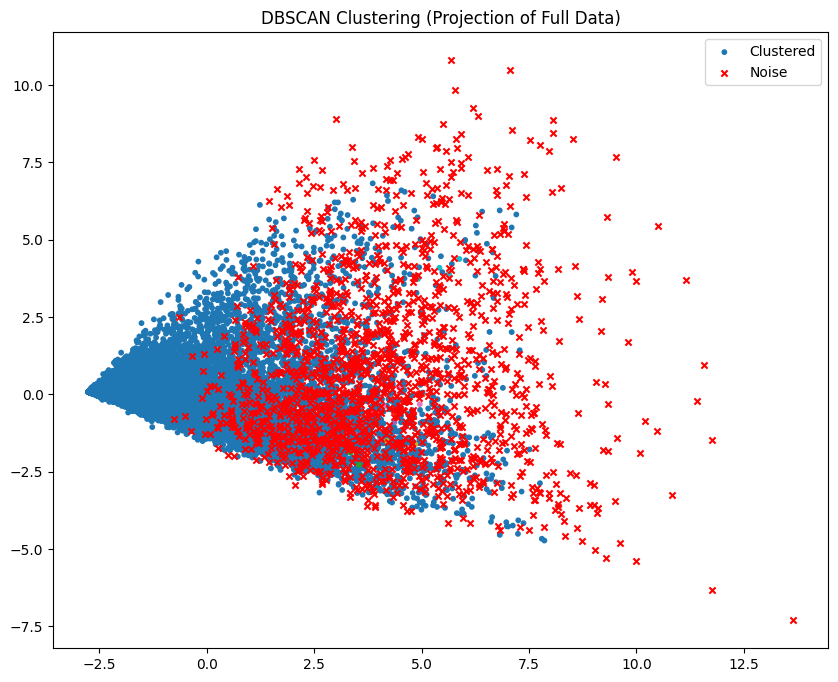

In [24]:
labels_dbscan_full = dbscan_final.fit_predict(data_final)
core_mask = labels_dbscan_full != -1
noise_mask = labels_dbscan_full == -1

plt.figure(figsize=(10, 8))
plt.scatter(data_pca[core_mask, 0], data_pca[core_mask, 1], c=labels_dbscan_full[core_mask], cmap='tab10', s=10, label='Clustered')
plt.scatter(data_pca[noise_mask, 0], data_pca[noise_mask, 1], c='red', marker='x', s=20, label='Noise')
plt.title(f'DBSCAN Clustering (Projection of Full Data)')
plt.legend()
plt.savefig(('images/model_dbscan_result.png'))
plt.show()
plt.close()

1. Use the Agglomerative Clustering model for bottom-up hierarchical clustering.
2. Adjust the hyperparameters' linkage 'and' n_clusters' to find the situation with the highest score among different cluster numbers and inter cluster distance measurement methods' ward ',' overage ', and' complete '. 

In [25]:
link = ['ward', 'average', 'complete']
bestlink = ''
best = -1
bestk = 2

for l in link:
    for k in range(2, 9):
        model = AgglomerativeClustering(n_clusters=k, linkage=l, metric='euclidean')
        labels = model.fit_predict(x_train)
        score = silhouette_score(x_train, labels)
        print(f"Linkage={l}, k={k}, Silhouette Score={score:.4f}")
        if score > best:
            best = score
            bestlink = l
            bestk = k

print(f"Best: k={bestk}, Linkage='{bestlink}', Silhouette Score={best:.4f}")

Linkage=ward, k=2, Silhouette Score=0.4237
Linkage=ward, k=3, Silhouette Score=0.4320
Linkage=ward, k=4, Silhouette Score=0.1998
Linkage=ward, k=5, Silhouette Score=0.2145
Linkage=ward, k=6, Silhouette Score=0.2218
Linkage=ward, k=7, Silhouette Score=0.2083
Linkage=ward, k=8, Silhouette Score=0.2091
Linkage=average, k=2, Silhouette Score=0.6168
Linkage=average, k=3, Silhouette Score=0.5379
Linkage=average, k=4, Silhouette Score=0.5340
Linkage=average, k=5, Silhouette Score=0.5272
Linkage=average, k=6, Silhouette Score=0.5159
Linkage=average, k=7, Silhouette Score=0.5140
Linkage=average, k=8, Silhouette Score=0.4818
Linkage=complete, k=2, Silhouette Score=0.5137
Linkage=complete, k=3, Silhouette Score=0.4757
Linkage=complete, k=4, Silhouette Score=0.3849
Linkage=complete, k=5, Silhouette Score=0.3975
Linkage=complete, k=6, Silhouette Score=0.3536
Linkage=complete, k=7, Silhouette Score=0.3511
Linkage=complete, k=8, Silhouette Score=0.3720
Best: k=2, Linkage='average', Silhouette Score=0

1. When Linkage=overview and k=2, evaluate Agglomerative Clustering on the validation set. 
2. Record the best results of Agglomerative Clustering. 

In [26]:
hc_final = AgglomerativeClustering(n_clusters=bestk, linkage=bestlink, metric='euclidean')
labels_val_hc = hc_final.fit_predict(x_val)
if len(np.unique(labels_val_hc)) >= 2:
    score3 = silhouette_score(x_val, labels_val_hc)
else:
    score3 = -1
results['Hierarchical'] = score3
print(f"Best Hierarchical Score: {score3:.4f}")

Best Hierarchical Score: 0.6075


Visualize the link matrix as a tree diagram with the training set sample index as the x-axis and the inter cluster distance as the y-axis.
Due to the large amount of training data, visualization only takes the first 200 samples from the training dataset. 

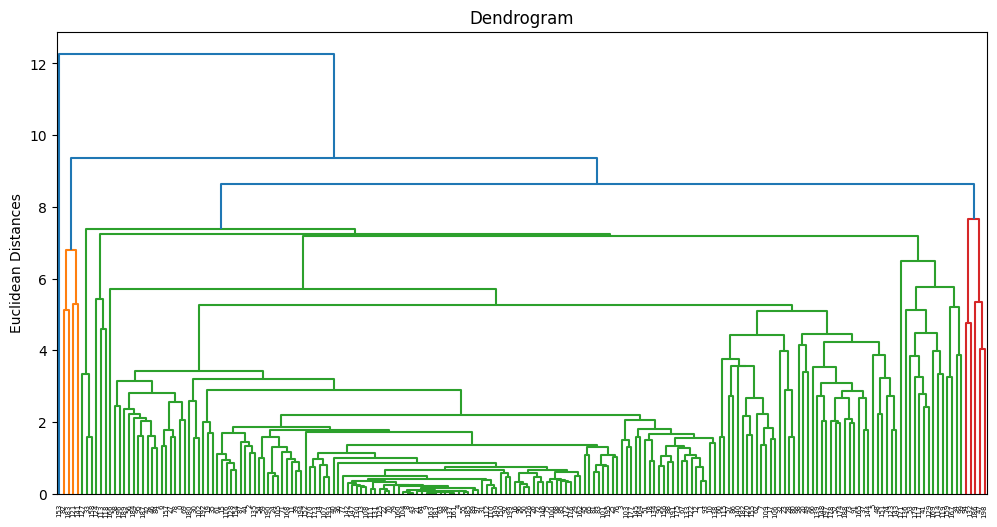

In [33]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(x_train[:200], method=bestlink))
plt.title(f'Dendrogram')
plt.ylabel('Euclidean Distances')
plt.savefig(os.path.join('images/model_hierarchical_dendrogram0.png'))
plt.show()
plt.close()

Compare the highest scores of the three methods. 

In [28]:
print("Comparision")
print(f"{'Model:        '} | {'Validation Score: '} ")
print(f"{'KMeans:       '} | {results['KMeans']:.4f} ")
print(f"{'DBSCAN:       '} | {results['DBSCAN']:.4f} ")
print(f"{'Hierarchical: '} | {results['Hierarchical']:.4f} ")

Comparision
Model:         | Validation Score:  
KMeans:        | 0.4600 
DBSCAN:        | 0.4466 
Hierarchical:  | 0.6075 


1. Use the model with the highest score as the final testing model to test the test set. 
2. Ultimately, conduct experiments using the model on the entire dataset. 


In [39]:
testmodel = AgglomerativeClustering(n_clusters=bestk, linkage=bestlink, metric='euclidean')
labels_test = testmodel.fit_predict(x_test)
score4 = silhouette_score(x_test, labels_test)
print(f"Best Model Test Score: {score4:.4f}")

finalmodel = AgglomerativeClustering(n_clusters=bestk, linkage=bestlink, metric='euclidean')
labelsfinal = finalmodel.fit_predict(data_final)
score4 = silhouette_score(data_final, labelsfinal)
print(f"Best Model Score on all datasets: {score4:.4f}")

Best Model Test Score: 0.7518
Best Model Score on all datasets: 0.6749


The visualization result of the final model on the entire dataset - scatter plot. 

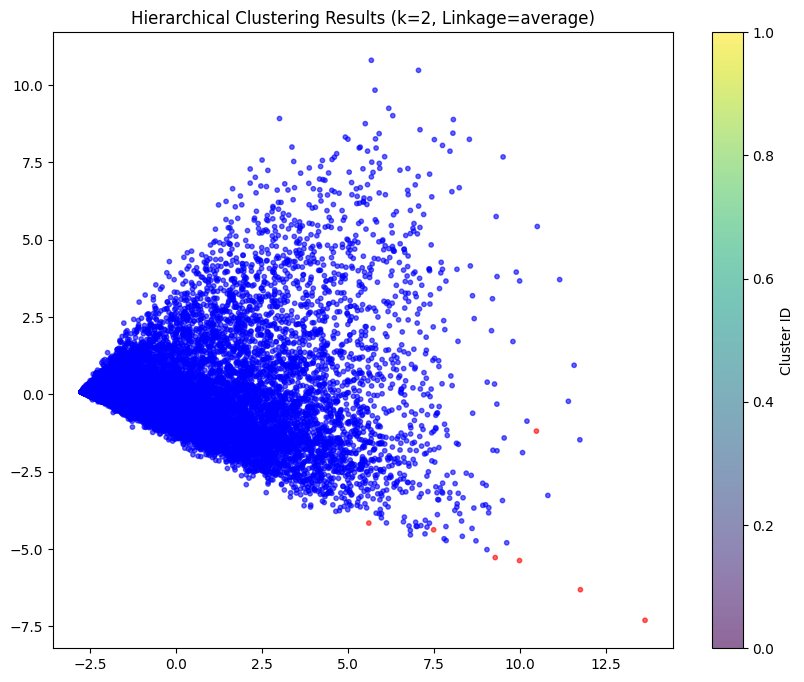

In [40]:
labels_hc_full = hc_final.fit_predict(data_final)
plt.figure(figsize=(10, 8))
colors = ['blue', 'red']
scatter =plt.scatter(data_pca[:, 0], data_pca[:, 1], c=[colors[i] for i in labels_hc_full], alpha=0.6, s=10)
plt.title(f'Hierarchical Clustering Results (k={bestk}, Linkage={bestlink})')
plt.colorbar(scatter, label='Cluster ID')
plt.savefig(os.path.join('images/model_hierarchical_result.png'))
plt.show()
plt.close()

The visualization result of the final model on the entire dataset-tree diagram. 

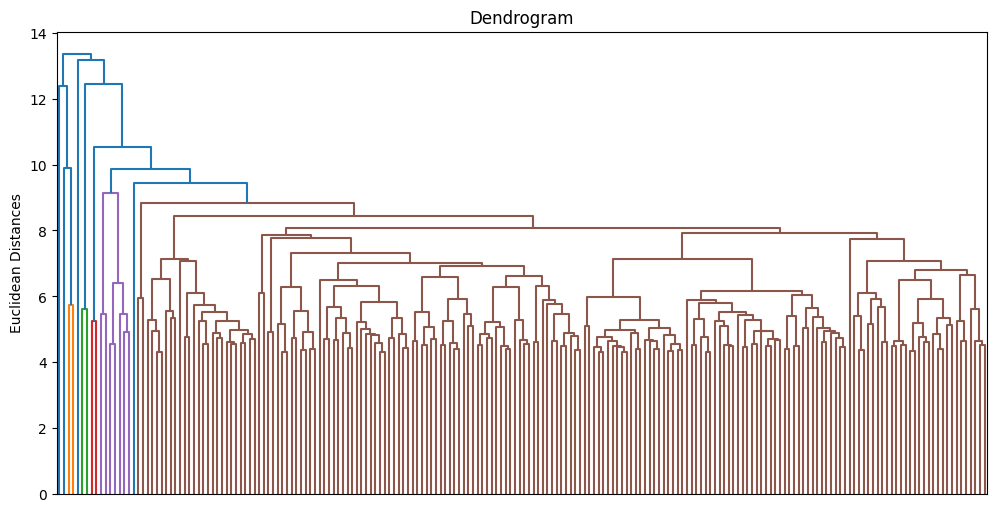

In [38]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(data_final, method=bestlink), 
                            truncate_mode='lastp',
                            p=200,
                            no_labels=True,)
plt.title(f'Dendrogram')
plt.ylabel('Euclidean Distances')
plt.savefig(os.path.join('images/model_hierarchical_dendrogram.png'))
plt.show()
plt.close()